In [1]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
from time import perf_counter_ns as pc

# New Mediapipe Solution

## Demo

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [3]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, result):
    hand_landmarks_list = result.hand_landmarks
    handedness_list = result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness[0].category_name}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image, hand_landmarks, handedness

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


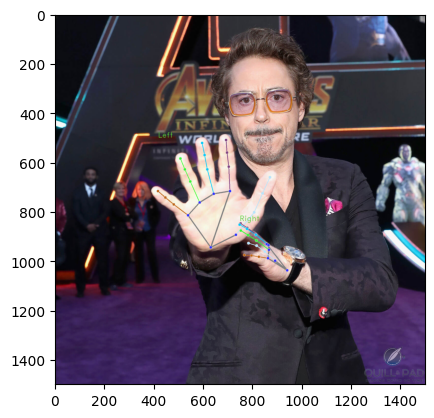

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

image = mp.Image.create_from_file("downey.jpg")

detection_result = detector.detect(image)

annotated_image, hand_landmarks, handedness = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.show()

In [5]:
def extract_hand(result):
    rh = lh = np.zeros((21, 3))
    
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):
        assert len(handedness) == 1, "Unexpected Error in handedness"
        
        if handedness[0].category_name == 'Left':
            lh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
        if handedness[0].category_name == 'Right':
            rh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
    
    hand_pose = np.concatenate((rh, lh), axis=0)
    return hand_pose

In [41]:
hand_pose = extract_hand(detection_result)
hand_pose.shape

(42, 3)

## Visualize Hand Pose

In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [8]:
data = np.load('../data/MyDataset/pose_ver2/s1_Jeremy_1.npy', allow_pickle=True).item()

In [33]:
for key in data.keys():
    p = data[key][:42]
    if p[:21].sum() != 0 and p[21:].sum() != 0:
        print(p)
        

<IPython.core.display.Javascript object>


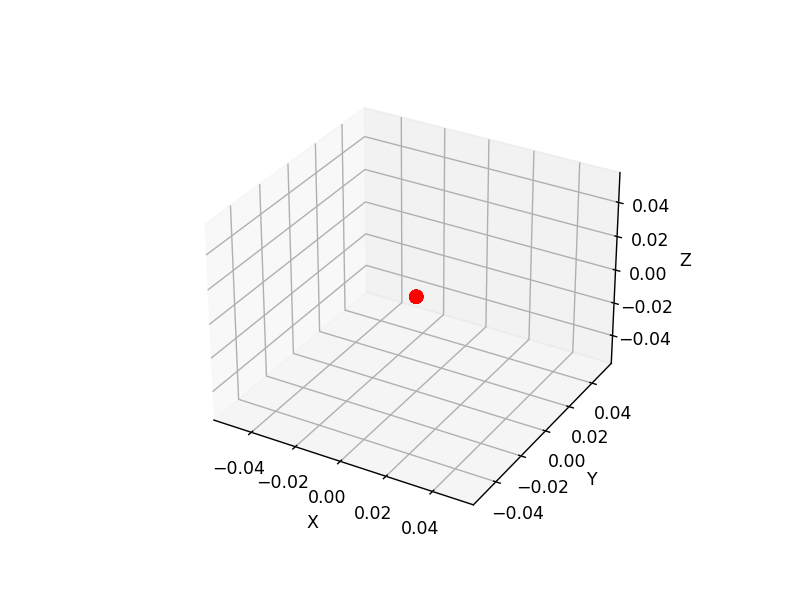

<IPython.core.display.Javascript object>


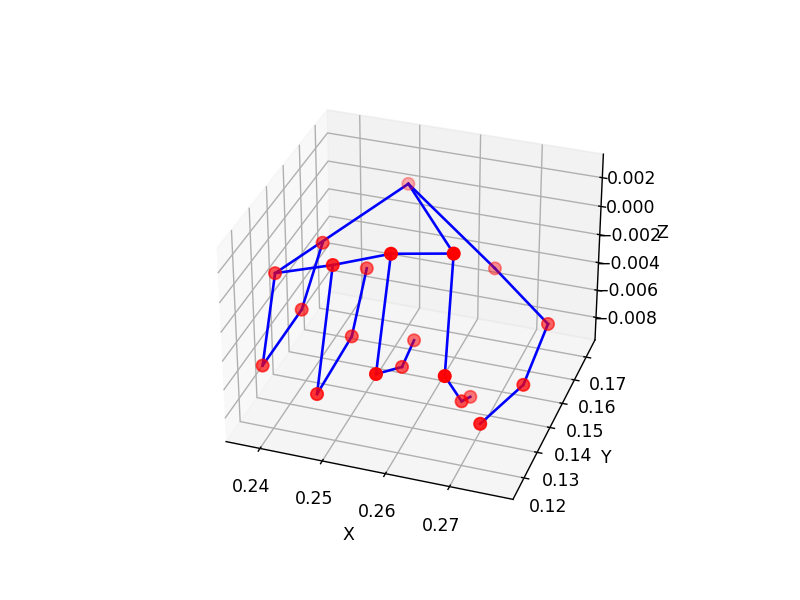

In [28]:
%matplotlib notebook

def plot_hand_connections(hand_points):
    connections = [
        (0, 1), (0, 5), (0, 17),
        (1, 2), (2, 3), (3, 4),
        (5, 6), (5, 9), (6, 7), (7, 8),
        (9, 10), (9, 13), (10, 11), (11, 12),
        (13, 14), (13, 17), (14, 15), (15, 16),
        (17, 18), (18, 19), (19, 20)
    ]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = hand_points[:, 0], hand_points[:, 1], hand_points[:, 2]
    ax.scatter(x, y, z, c='r', marker='o', s=50)
    
    for connection in connections:
        start_point = hand_points[connection[0]]
        end_point = hand_points[connection[1]]
        ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], 'b')

#     # Plot flipped hand
#     transformed_hand = hand_points.copy()
#     transformed_hand[:, 0] = -transformed_hand[:, 0]
#     #transformed_hand[:, 1] = -transformed_hand[:, 1]
#     x, y, z = transformed_hand[:, 0], transformed_hand[:, 1], transformed_hand[:, 2]
#     ax.scatter(x, y, z, c='r', marker='o', s=50)
#     print(transformed_hand[10, 1])
#     for connection in connections:
#         start_point = transformed_hand[connection[0]]
#         end_point = transformed_hand[connection[1]]
#         ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], 'b')

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

hand_pose = data[328]
plot_hand_connections(hand_pose[:21])
plot_hand_connections(hand_pose[21:42])

[6.27607465e-01 6.92661226e-01 3.24028626e-08]


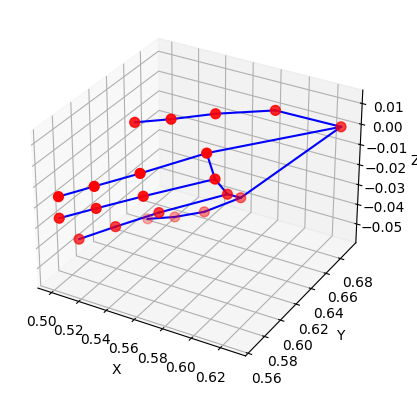

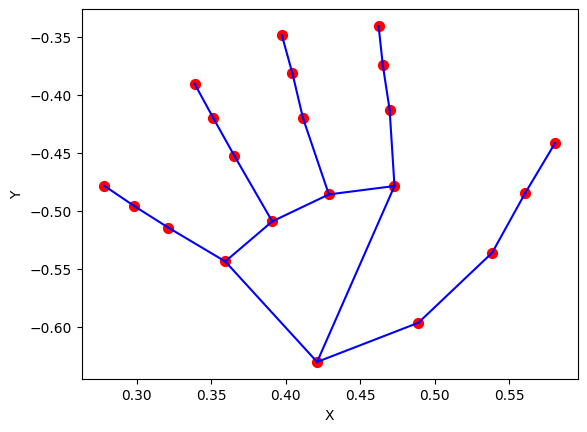

In [68]:
flip_pose = hand_pose.copy()
flip_pose[:, 1] = -flip_pose[:, 1]
plot_hand_connections(flip_pose[21:])

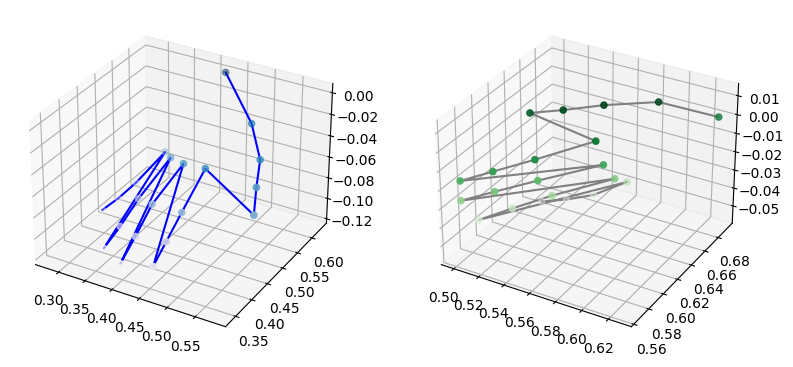

In [92]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(xl, yl, zl, 'blue')
ax.scatter3D(xl, yl, zl, c=zl, cmap='PuBu');

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot3D(xr, yr, zr, 'gray')
ax.scatter3D(xr, yr, zr, c=zr, cmap='Greens');

## Extract from video

In [2]:
def extract_hand(result):
    rh = lh = np.zeros((1, 3))
    
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):
        assert len(handedness) == 1, "Unexpected Error in handedness"
        
        if handedness[0].category_name == 'Left':
            lh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
        if handedness[0].category_name == 'Right':
            rh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
    hand_pose = np.concatenate((rh, lh), axis=0)
    return hand_pose


def extract_arm(result):
    extracted_keypoints = [
        solutions.pose.PoseLandmark.LEFT_SHOULDER.value,
        solutions.pose.PoseLandmark.RIGHT_SHOULDER.value,
        solutions.pose.PoseLandmark.LEFT_ELBOW.value,
        solutions.pose.PoseLandmark.RIGHT_ELBOW.value,
        solutions.pose.PoseLandmark.LEFT_WRIST.value,
        solutions.pose.PoseLandmark.RIGHT_WRIST.value
    ]
    n_keypoints = len(extracted_keypoints)
    arm_pose = np.zeros((n_keypoints, 3))
    
    for landmarks in result.pose_landmarks:
        extracted_lms = [landmarks[i] for i in extracted_keypoints]
        for i in range(n_keypoints):
            lm = extracted_lms[i]
            arm_pose[i] = (lm.x, lm.y, lm.z)
            
    return arm_pose    


def draw_hand(annotated_image, result):
    
    MARGIN = 10  # pixels
    FONT_SIZE = 1
    FONT_THICKNESS = 1
    HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green
    
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness[0].category_name}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image
def draw_arm(annotated_image, result):
    
    for pose_landmarks in result.pose_landmarks:

        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

In [28]:
import mediapipe as mp
from time import perf_counter_ns as pc

# Define variables
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions

PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions


# Create a hand landmarker instance with the video mode:
hand_options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2)

arm_options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="pose_landmarker_full.task"),
    running_mode=VisionRunningMode.VIDEO)


with HandLandmarker.create_from_options(hand_options) as hand_landmarker, \
        PoseLandmarker.create_from_options(arm_options) as arm_landmarker:
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        frame_timestamp_ms = int(pc() // 1e+6)
        annotated_frame = np.copy(frame)
        
        # Process hand
        hand_result = hand_landmarker.detect_for_video(mp_image, frame_timestamp_ms)
        hand_pose = extract_hand(hand_result)
        annotated_frame = draw_hand(annotated_frame, hand_result)
        
        # Process arm
        arm_result = arm_landmarker.detect_for_video(mp_image, frame_timestamp_ms)
        arm_pose = extract_arm(arm_result)
        print(arm_pose.shape)
        annotated_frame = draw_arm(annotated_frame, arm_result)
        
        cv2.imshow("", annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)

In [8]:
cap.release()

## Visualize Arm Pose

In [12]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

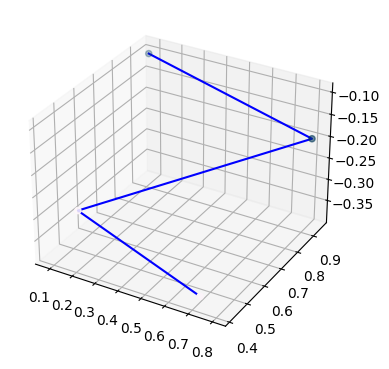

In [29]:
x = arm_pose[:4, 0]
y = arm_pose[:4, 1]
z = arm_pose[:4, 2]

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(x, y, z, 'blue')
ax.scatter3D(x, y, z, c=y, cmap='PuBu');

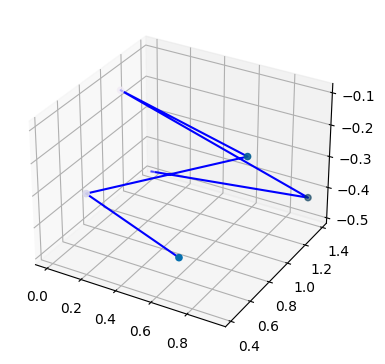

In [30]:
x = arm_pose[:, 0]
y = arm_pose[:, 1]
z = arm_pose[:, 2]

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(x, y, z, 'blue')
ax.scatter3D(x, y, z, c=x, cmap='PuBu');

# Mediapipe Legacy

In [11]:
arm_pose.shape

(6, 3)

In [10]:
import cv2
import mediapipe as mp

# Grabbing the Holistic Model from Mediapipe and
# Initializing the Model
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
 
# Initializing the drawing utils for drawing the facial landmarks on image
mp_drawing = mp.solutions.drawing_utils

In [147]:
def get_coord(hand):
    landmarks = []
    
    for lm in hand.landmark:
        x = lm.x
        y = lm.y
        z = lm.z
        landmarks.append([x, y, z])
    landmarks = np.array(landmarks)
    print(landmarks.shape)
    return landmarks


def dict2numpy(hand_dict):
    hand_pose = np.zeros((42, 3))
    
    if hand_dict == {}:
        return {}
        #return hand_pose
    
    for handedness in hand_dict.keys():
        if handedness == 'Right':
            hand_pose[:21] = hand_dict['Right']
            # print('RIGHT')
        elif handedness == 'Left':
            hand_pose[21:] = hand_dict['Left']
            # print('LEFT')
            
    return hand_pose


def extract_hand(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))
    return np.concatenate([lh, rh], axis=0)

In [ ]:
cap = cv2.VideoCapture(0)
frame_counter = 0
result_pose = {}

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        success, image = cap.read()
        frame_counter += 1

        if not success:
          break

        image.flags.writeable = False
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(rgb_image)
        image.flags.writeable = True
        
        # Extract hand pose
        hand_pose = extract_hand(results)
        
        # Extract arm pose
        
#         result_pose[frame_counter] = hand_pose
        
        cv2.imshow('', image)
        
        if cv2.waitKey(5) & 0xFF == ord('q'):
          break
        
cap.release()
cv2.destroyAllWindows()

In [134]:
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])

In [135]:
lh.shape

(21, 3)